In [ ]:
import hopsworks

project = hopsworks.login()
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Multiple projects found. 

	 (1) dancip00
	 (2) goodonions_id2223_lab1
Invalid input, should be an integer from the list of projects.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/217237
Connected. Call `.close()` to terminate connection gracefully.


In [29]:
# The feature view is the input set of features for your model. The features can come from different feature groups.
# You can select features from different feature groups and join them together to create a feature view
salary_fg = fs.get_feature_group(name="salary", version=2)
query = salary_fg.select_all()
feature_view = fs.get_or_create_feature_view(name="salary",
                                             query=query,
                                             labels=["salary_bins"],
                                             version=2)

In [45]:
X_train, X_test, y_train, y_test = feature_view.train_test_split(test_size=0.2)

Finished: Reading data from Hopsworks, using ArrowFlight (1.28s) 


In [46]:
'''
y_train = X_train["salary_bins"]
y_test = X_test["salary_bins"]
'''
X_train = X_train.drop(columns=[ "salary"])
X_test = X_test.drop(columns=["salary"])


In [47]:
X_train.head()

,work_year,experience_level,company_size,eur,gbp,usd,engineer,scientist,research,analyst,...,data_science_manager,data_scientist,ml_engineer,machine_learning_engineer,machine_learning_scientist,research_analyst,research_engineer,research_scientist,gdp,cpi
0,2023,2,1,False,False,True,1,0,0,0,...,False,False,False,False,False,False,False,False,2.543970e+13,134.211206
1,2022,2,1,False,False,True,0,0,0,1,...,False,False,False,False,False,False,False,False,2.543970e+13,134.211206
2,2023,2,1,False,False,True,1,0,0,0,...,False,False,False,False,False,False,False,False,2.543970e+13,134.211206
4,2023,1,1,False,False,True,1,0,0,0,...,False,False,False,False,False,False,False,False,2.543970e+13,134.211206
6,2023,1,1,False,False,True,1,0,0,0,...,False,False,False,False,False,False,False,False,2.543970e+13,134.211206


In [48]:
#remove is not a number values in the dataset
X_train['salary_bins']= y_train
X_train = X_train.dropna()
y_train = X_train["salary_bins"]
X_train = X_train.drop(columns=["salary_bins"])

X_test['salary_bins']= y_test
X_test = X_test.dropna()
y_test = X_test["salary_bins"]
X_test = X_test.drop(columns=["salary_bins"])

In [49]:
# Random Forest and Grid Search

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

param_grid = [
    {'max_leaf_nodes': range(20, 30, 1)},
]

rnd_clf = RandomForestClassifier(random_state=42, bootstrap=True, n_jobs=2)
grid_search = GridSearchCV(rnd_clf, param_grid, cv=5, scoring='accuracy', return_train_score=True, n_jobs=4)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=2, random_state=42),
             n_jobs=4, param_grid=[{'max_leaf_nodes': range(20, 30)}],
             return_train_score=True, scoring='accuracy')

In [50]:
y_pred = grid_search.predict(X_test)
accuracy_score(y_test, y_pred)

0.5788876276958003

In [51]:
grid_search.best_params_

{'max_leaf_nodes': 28}

In [52]:
rnd_clf = RandomForestClassifier(random_state=42, max_leaf_nodes=25, bootstrap=True, n_jobs=2)
rnd_clf.fit(X_train, y_train)

y_pred = rnd_clf.predict(X_test)
ac = accuracy_score(y_test, y_pred)

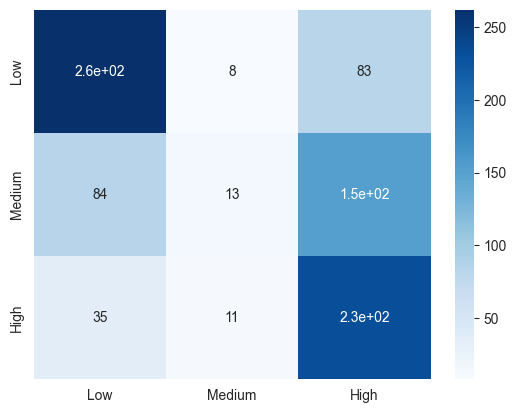

In [53]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report
import pandas as pd

metrics = classification_report(y_test, y_pred, output_dict=True)

results = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(results, ["Low", "Medium", "High"], columns=["Low", "Medium", "High"])
cm = sns.heatmap(df_cm, annot=True, cmap="Blues")
fig = cm.get_figure()

# Model upload to Hopsworks

In [55]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
import joblib
import os

mr = project.get_model_registry()

model_dir = "model_salary"
if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)

joblib.dump(rnd_clf, os.path.join(model_dir, "model.pkl"))
fig.savefig(os.path.join(model_dir, "confusion_matrix.png"))

input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema, output_schema)

salary_model = mr.python.create_model(
    name="salary_model",
    metrics={"accuracy": ac},
    model_schema=model_schema,
    description="Salary Predictor"
)

salary_model.save(model_dir)

Connected. Call `.close()` to terminate connection gracefully.


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/17725 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/474321 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/2409 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/217237/models/salary_model/5


Model(name: 'salary_model', version: 5)